In [ ]:
import torch, os, random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow as tf

from models.decoder import Decoder
from models.encoder import Encoder
from utils.dataset_C111 import SpinodoidC111Dataset
from utils.dataset_C212 import SpinodoidC212Dataset
from utils.sampling import get_S_hats, get_S_hat_peaks
from utils.fNN_layers import *
from utils.load_data import extract_target_properties, full_C_from_C_flat_21
from config import *

# === settings ===
SEED = 42
COMPONENT_NAME = "C111"  # or "C212"
COMPONENT_INDEX = 0 if COMPONENT_NAME == "C111" else 6

# === set seed ===
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === choose trial ===
trial = 3
trial_dir = f"checkpoints/{COMPONENT_NAME}_trial_{trial}"
decoder_path = f"{trial_dir}/decoder_ckpt_{trial}.pt"
encoder_path = f"{trial_dir}/encoder_ckpt_{trial}.pt"
config_path  = f"{trial_dir}/config_{trial}.txt"

In [20]:
# === load config ===
with open(config_path) as f:
    config = {line.split(":")[0].strip(): eval(line.split(":")[1].strip()) for line in f}
LATENT_DIM = config["LATENT_DIM"]
S_DIM = config["S_DIM"]
P_DIM = config["P_DIM"]
ENCODER_HIDDEN_DIMS = config["ENCODER_HIDDEN_DIMS"]
DECODER_HIDDEN_DIMS = config["DECODER_HIDDEN_DIMS"]

# === load dataset ===
dataset = SpinodoidC111Dataset(DATA_PATH) if COMPONENT_NAME == "C111" else SpinodoidC212Dataset(DATA_PATH)
P_all, S_all = dataset.P, dataset.S
P_target = P_all[0].unsqueeze(0).to(device)
S_true = S_all[0].detach().cpu().numpy()

# === load models ===
encoder = Encoder(S_DIM, P_DIM, LATENT_DIM, ENCODER_HIDDEN_DIMS).to(device)
encoder.load_state_dict(torch.load(encoder_path, map_location=device))
encoder.eval()

decoder = Decoder(S_DIM, P_DIM, LATENT_DIM, DECODER_HIDDEN_DIMS).to(device)
decoder.load_state_dict(torch.load(decoder_path, map_location=device))
decoder.eval()

print("✅ Models loaded for trial", trial)

✅ Models loaded for trial 2


/var/folders/9z/9fdpt4_148s8zzl9h0tr9dgw0000gn/T/ipykernel_83525/4019097158.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load(encoder_p

In [21]:
# === load Max’s fNN model ===
custom_objects = {
    'PermutationEquivariantLayer': PermutationEquivariantLayer,
    'DoubleContractionLayer': DoubleContractionLayer,
    'EnforceIsotropyLayer': EnforceIsotropyLayer,
    'NormalizationLayer': NormalizationLayer
}
fNN = tf.keras.models.load_model('utils/max_fNN.h5', custom_objects=custom_objects)
print("✅ Loaded Max's forward model")

✅ Loaded Max's forward model


In [22]:
# === sample Ŝ from decoder and extract peaks ===
S_hats = get_S_hats(decoder, P_target, LATENT_DIM, num_samples=1000, device=device)
S_hat_peaks = get_S_hat_peaks(S_hats, bandwidth=20.0)
print(f"✅ Sampled {len(S_hat_peaks)} peaks")

# === evaluate peak predictions using fNN ===
S_hat_peaks_tensor = torch.tensor(S_hat_peaks, dtype=torch.float32)
P_preds_all = []

for s_hat in S_hat_peaks_tensor:
    s_hat_np = s_hat.unsqueeze(0).unsqueeze(0).numpy()  # shape: (1, 1, 4)
    C_tensor_pred = fNN.predict(s_hat_np, verbose=0)    # shape: (1, 1, 3, 3, 3, 3)
    C_tensor_pred = np.squeeze(C_tensor_pred, axis=1)   # shape: (1, 3, 3, 3, 3)

    P_pred_vec = extract_target_properties(C_tensor_pred)[0]  # shape: (9,)
    P_pred_scalar = P_pred_vec[COMPONENT_INDEX].item()
    P_preds_all.append(P_pred_scalar)


✅ Sampled 8 peaks



✅  Error across 8 peak predictions:
   - MSE: 0.100168
   - MAE: 0.196046
   - True C111 value: 0.54746
   - Predicted C111 values: [0.53435 0.69441 0.50885 0.6769  1.38494 0.61934 0.38673 0.37729]


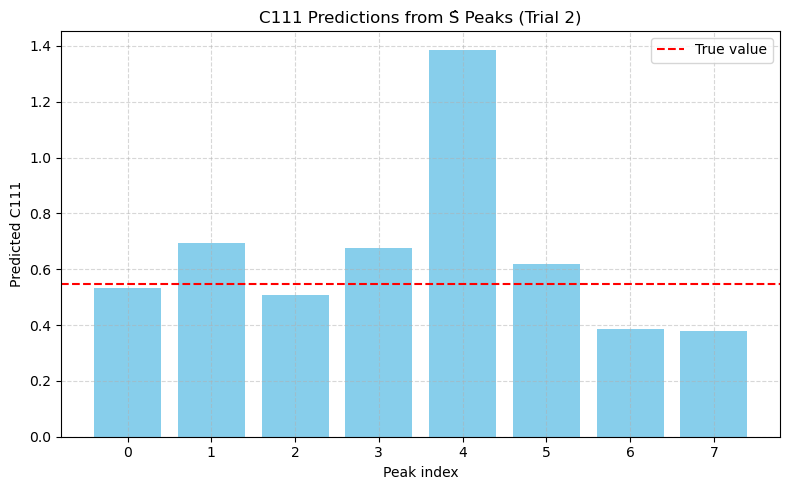

In [23]:
# === compare with true P ===
from sklearn.metrics import mean_squared_error
import numpy as np

P_true_scalar = P_target.cpu().numpy().flatten()[0]
P_preds_all = np.array(P_preds_all)

mse = mean_squared_error([P_true_scalar] * len(P_preds_all), P_preds_all)
mae = np.mean(np.abs(P_preds_all - P_true_scalar))

print(f"\n✅  Error across {len(P_preds_all)} peak predictions:")
print(f"   - MSE: {mse:.6f}")
print(f"   - MAE: {mae:.6f}")
print(f"   - True {COMPONENT_NAME} value: {P_true_scalar:.5f}")
print(f"   - Predicted {COMPONENT_NAME} values: {np.round(P_preds_all, 5)}")

# === plot prediction bar chart ===
plt.figure(figsize=(8, 5))
plt.bar(np.arange(len(P_preds_all)), P_preds_all, color='skyblue')
plt.axhline(P_true_scalar, color='red', linestyle='--', label='True value')
plt.xlabel("Peak index")
plt.ylabel(f"Predicted {COMPONENT_NAME}")
plt.title(f"{COMPONENT_NAME} Predictions from Ŝ Peaks (Trial {trial})")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
